<a href="https://colab.research.google.com/github/tomek-l/fire/blob/master/4.1CAM_grad_one_shot(SacramentoTestBurn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verify the model on never seen images


In [67]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=False)

#declare program constants
ROOT_DIR = '/gdrive/My Drive/fire_dataset/sacramento_test_burn/DJI_0002_out/'
FRAMES_DIR = ROOT_DIR + 'frames/'
HM_DIR = ROOT_DIR + 'heatmaps/'
!mkdir -p '$FRAMES_DIR'
!mkdir -p '$HM_DIR'
IMAGE_NUM = 9999999

Mounted at /gdrive


In [0]:
!ls '$FRAMES_DIR' | wc
!ls '$HM_DIR' | wc

  24565   24565  393040
  21306   42612  404814


In [0]:
!ffmpeg -i '/gdrive/My Drive/fire_dataset/sacramento_test_burn/DJI_0002.MOV' -vf fps=30 -q:v 1 '$FRAMES_DIRframe%5d.jpg'

In [0]:
image_names = os.listdir(FRAMES_DIR)
image_names.sort()
image_names = image_names[21306:]

# Load the fire detection model

In [0]:
from IPython.display import clear_output
from keras.models import load_model
model = load_model('/gdrive/My Drive/fire_dataset/models/VGG_monolth_30epochs.h5')
clear_output()

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np

def get_processed_image(img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255. #(the network is trained on 0.0-1.0 inputs)
  return img_tensor

In [0]:
#Build graph for CAM-grad process
import keras.backend as K

binary_fire_output = model.output
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(model.output, last_conv_layer.output)[0]
print(grads)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads)

Tensor("gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 9, 9, 512), dtype=float32)
Tensor("Mean:0", shape=(512,), dtype=float32)


In [0]:
len(image_names)

3259

# Run CAM grad process & create heatmaps

0 / 3259
0


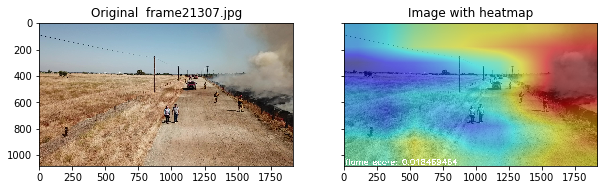

100 / 3259
100


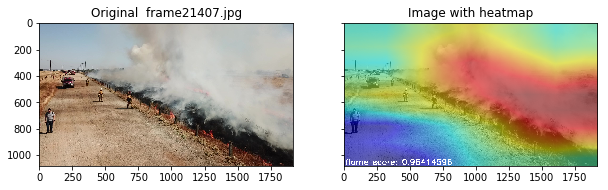

200 / 3259
200


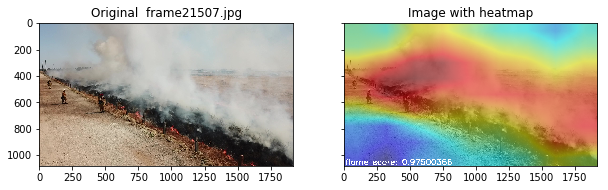

300 / 3259
300


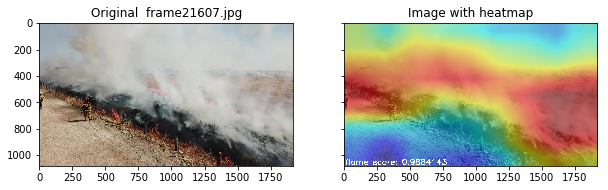

400 / 3259
400


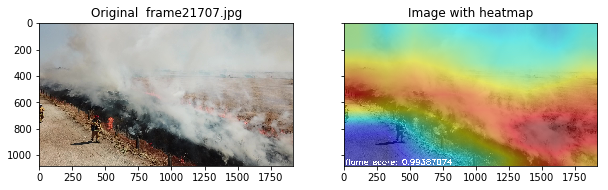

500 / 3259
500


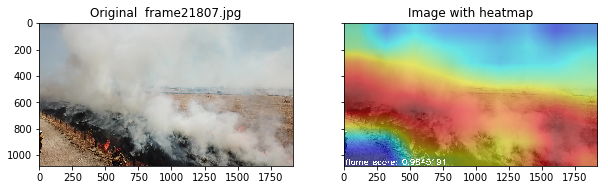

600 / 3259
600


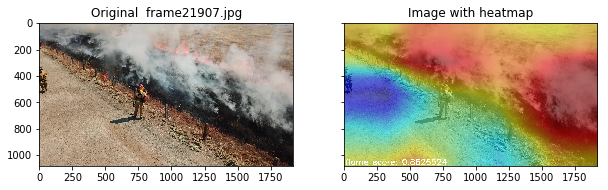

700 / 3259
700


800 / 3259
800


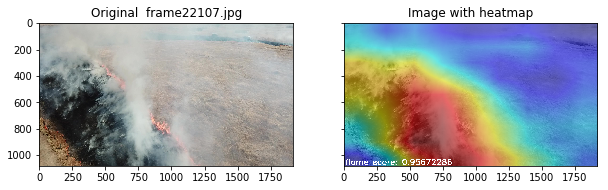

900 / 3259
900


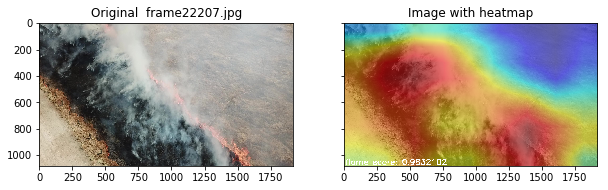

1000 / 3259
1000


1100 / 3259
1100


1200 / 3259
1200


1300 / 3259
1300


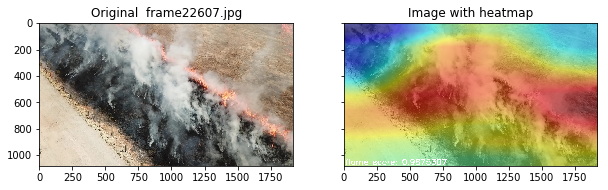

1400 / 3259
1400


1500 / 3259
1500


1600 / 3259
1600


1700 / 3259
1700


1800 / 3259
1800


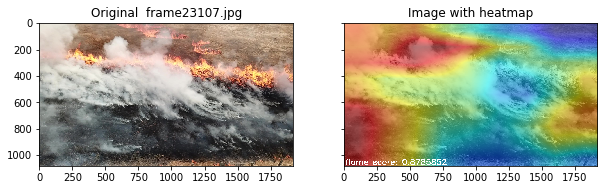

1900 / 3259
1900


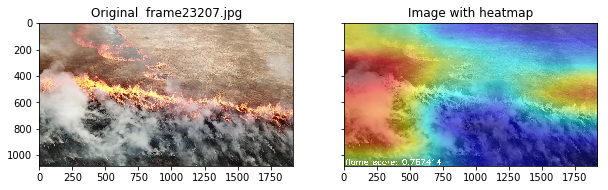

2000 / 3259
2000


2100 / 3259
2100


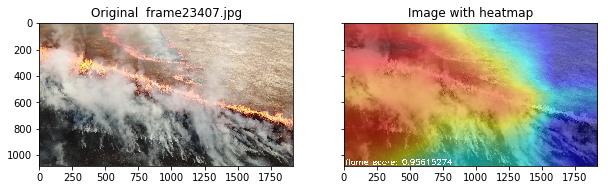

2200 / 3259
2200


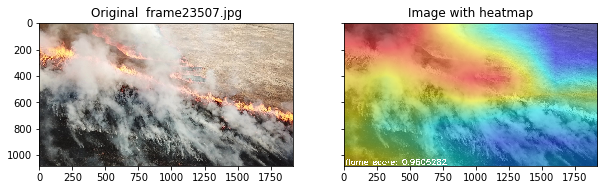

2300 / 3259
2300


2400 / 3259
2400


2500 / 3259
2500


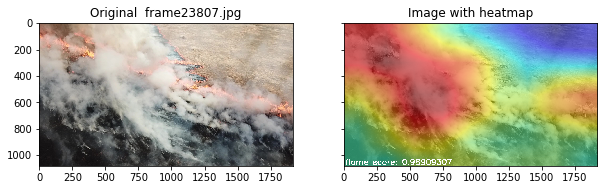

2600 / 3259
2600


2700 / 3259
2700


2800 / 3259
2800


2900 / 3259
2900


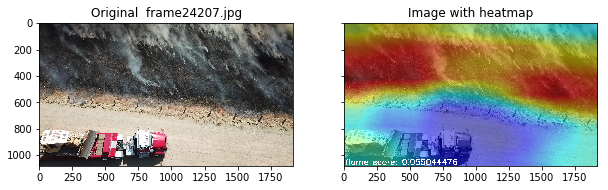

3000 / 3259
3000


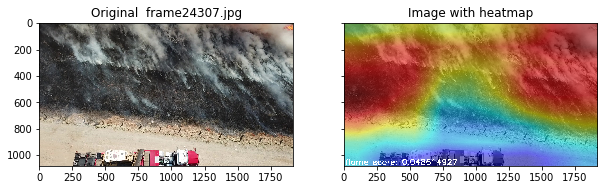

3100 / 3259
3100


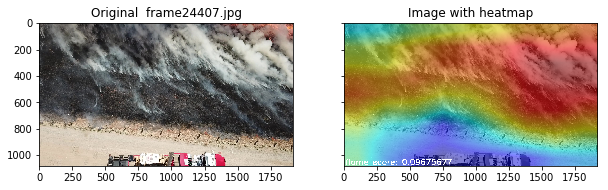

3200 / 3259
3200


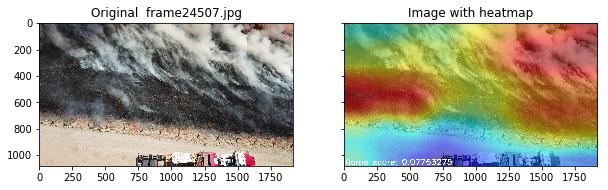

In [0]:
import os
import cv2
import matplotlib.pyplot as plt

for idx, name in enumerate(image_names):
  

  if idx % 100 == 0: print(idx , "/", len(image_names))
  img_path = FRAMES_DIR + name
  img_tensor = get_processed_image(img_path)

  # Heatmap generation
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
  for i in range(512):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  #normalize the heatmaps in (0,255)
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  hm_positive = heatmap + np.abs(np.min(heatmap))
  hm_normalized = np.array(255 * hm_positive/np.max(hm_positive), dtype=np.uint8)
  
  #run inference
  score = model.predict(img_tensor)[0][0]
  
  #create grayscale image
  img = cv2.imread(img_path)
  grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  grayimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2BGR)
  
  #apply heatmap
  hm = hm_normalized
  hm = cv2.resize(hm, (img.shape[1], img.shape[0]))
  hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
  superimposed_img = np.uint8(0.5* hm + 0.5* grayimg)
  
  #overlay score onto teimage
  cv2.putText(superimposed_img, 'flame score: '+str(score),
              (10, 1070), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=5)
  
  #save image
  img_abs_path = HM_DIR+'hm_'+name.split('.')[0]+'.jpg'
  cv2.imwrite(HM_DIR+'hm_'+name.split('.')[0]+'.jpg', superimposed_img)
  
  #visualize every n images
  if(idx%100==0):
    print(idx)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original ' + name)
    ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))  
    ax2.set_title('Image with heatmap')
    plt.show()


In [0]:
# ffmpeg conversions (back and forth)
#!ffmpeg -i '/gdrive/My Drive/fire_dataset/sacramento_test_burn/DJI_0003.MOV' -vf fps=30 -q:v 1 '/gdrive/My Drive/fire_dataset/sacramento_test_burn/DJI_0003_frames/out%5d.jpg'
#!ffmpeg -i /gdrive/My\ Drive/fire_dataset/sacramento_test_burn/DJI_0003_out/heatmaps/out%05d_heatmap.jpg /gdrive/My\ Drive/fire_dataset/sacramento_test_burn/DJI_0003_out/video_full.mp4

In [0]:
!ffmpeg -i /gdrive/My\ Drive/fire_dataset/sacramento_test_burn/DJI_0002_out/heatmaps/hm_\ frame%05d.jpg /gdrive/My\ Drive/fire_dataset/sacramento_test_burn/DJI_0002_out/video_full.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena